# Prototype calculation of cabelling and mixing of density from CM2.6 data <a class="anchor" id="top"> </a>

In [36]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [37]:
client

<Client: 'tls://10.0.3.30:8786' processes=0 threads=0, memory=0 B>

In [58]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [39]:
wet_mask = eroded_mask1#coord.wet
dxt = coord.dxt
dyt = coord.dyt
dxu = coord.dxu
dyu = coord.dyu
area_t = coord.area_t
kappa = 10 #m^2/s

In [40]:
grid = xgcm.Grid(ds.drop_dims('time'), coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [41]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    area_t:   Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
    dxu:      Annotated[np.ndarray, "(Y:right, X:right)"],
    dyu:      Annotated[np.ndarray, "(Y:right, X:right)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian for MOM5 (tracer points).
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    Attributes
    __________
    For information on MOM5 discretization see: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxt: width in x of T-cell, model diagnostic dxt
    dyt: height in y of T-cell, model diagnostic dyt
    dxu: width in x of U-cell, model diagnostic dxu
    dyu: height in y of U-cell, model diagnostic dyu
    area_t: area of T-cell, dxt*dyt
    """    
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
#    np = get_array_module(tracer)
    tracer = np.nan_to_num(tracer)
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    fx /= dxu + np.roll(dxu, 1, axis=-1)
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    fy /= dyu + np.roll(dyu, 1, axis=-2)
    fx *= x_wet_mask
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyt + np.roll(dyt, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyt + np.roll(dyt, 1, axis=-2))
    )
    out1 /= area_t

    out2 = fy * 0.5 * (dxt + np.roll(dxt, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxt + np.roll(dxt, 1, axis=-1))
    )
    out2 /= area_t
    return out1 + out2

In [42]:
axis = 7*[('Y','X')]

#### Erode the coastlines in mask before splitting up by basin

In [7]:
#From Paige - using the image to pad the land mask to check if the issue is with the land.
from skimage.morphology import dilation, erosion, disk

In [8]:
#testing diff disk sizes to see how it influences histogram values
wet_copy20 = coord.wet.copy()
eroded_mask20 = wet_copy20
eroded_mask20.data = erosion(eroded_mask20, footprint=disk(20))

In [28]:
wet_copy1 = coord.wet.copy()
eroded_mask1 = wet_copy1
eroded_mask1.data = erosion(eroded_mask1, footprint=disk(1))

In [29]:
wet_copy6 = coord.wet.copy()
eroded_mask6 = wet_copy6
eroded_mask6.data = dilation(eroded_mask6, footprint=disk(6))

In [20]:
eroded_mask1

<xarray.DataArray 'wet' (yt_ocean: 2700, xt_ocean: 3600)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet       (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:  land/sea flag (0=land) for T-cell
    units:      none

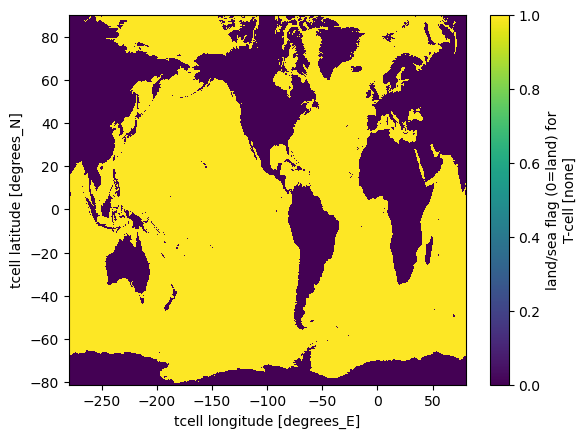

In [10]:
eroded_mask1.plot()

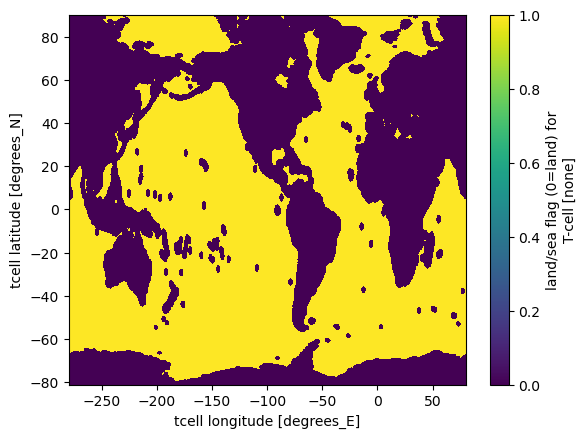

In [11]:
eroded_mask20.plot()

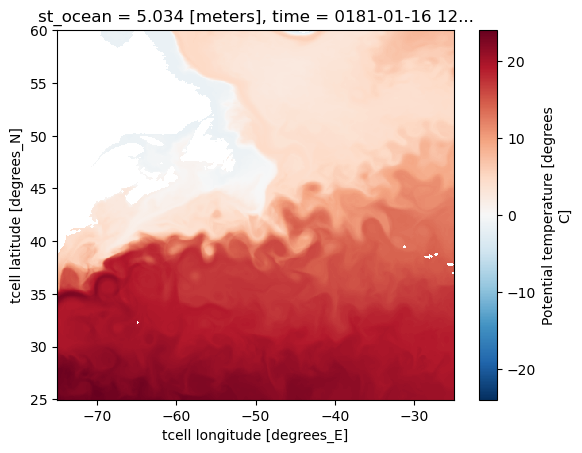

In [27]:
ds.temp.isel(st_ocean=0, time=0).where(eroded_mask1).sel(**selection).plot()

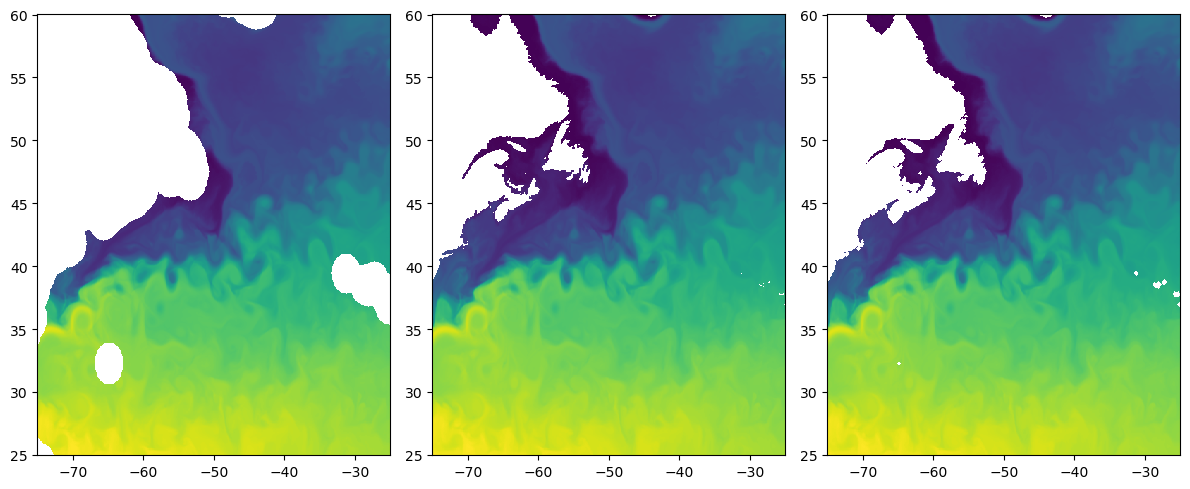

In [30]:
#selection = dict(yt_ocean=slice(-70,-60), xt_ocean=slice(-60,-50))
selection = dict(xt_ocean=slice(-75,-25), yt_ocean=slice(25,60))

fig, (ax0,ax1, ax2) = plt.subplots(1,3, figsize=(12,5))
ax0.pcolormesh(ds.xt_ocean.sel(xt_ocean=slice(-75,-25)), ds.yt_ocean.sel(yt_ocean=slice(25,60)), 
               ds.temp.isel(time=0, st_ocean=0).sel(**selection).where(eroded_mask20.sel(**selection)))
ax1.pcolormesh(ds.xt_ocean.sel(xt_ocean=slice(-75,-25)), ds.yt_ocean.sel(yt_ocean=slice(25,60)), 
               ds.temp.isel(time=0, st_ocean=0).sel(**selection).where(eroded_mask6.sel(**selection)))
ax2.pcolormesh(ds.xt_ocean.sel(xt_ocean=slice(-75,-25)), ds.yt_ocean.sel(yt_ocean=slice(25,60)), 
               ds.temp.isel(time=0, st_ocean=0).sel(**selection).where(eroded_mask1.sel(**selection)))
plt.tight_layout();

#### TESTING w 10x10 mask and tracer field

In [31]:
selection = dict(yt_ocean=slice(-70,-60), xt_ocean=slice(-60,-50))
sel_u = dict(yu_ocean=slice(-70,-60), xu_ocean=slice(-60,-50))
simple_temp = ds.temp.isel(time=0, st_ocean=0).sel(**selection)
simple_grid = eroded_mask1.sel(**selection)
dxt10 = coord.dxt.sel(**selection)
dyt10 = coord.dyt.sel(**selection)
dxu10 = coord.dxu.sel(**sel_u)
dyu10 = coord.dyu.sel(**sel_u)
area_t10 = coord.area_t.sel(**selection)
kappa = 10 #m^2/s

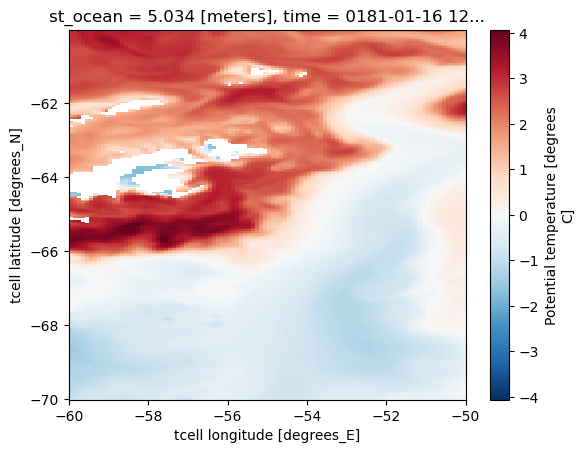

In [13]:
simple_temp.plot()

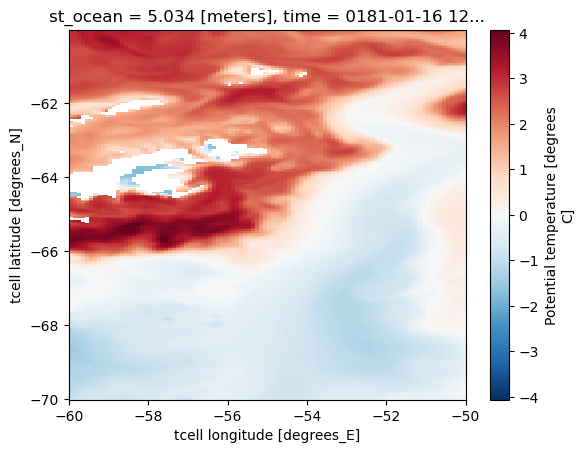

In [15]:
simple_temp.where(simple_grid).plot()

In [32]:
ds10 = ds.sel(**selection, **sel_u)

In [33]:
grid10 = xgcm.Grid(ds10.drop_dims('time'), coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [34]:
#Laplacian routine for simple 10x10
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    simple_grid: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxt10:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyt10:      Annotated[np.ndarray, "(Y:center, X:center)"],
    area_t10:   Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
    dxu10:      Annotated[np.ndarray, "(Y:right, X:right)"],
    dyu10:      Annotated[np.ndarray, "(Y:right, X:right)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian for MOM5 (tracer points).
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    Attributes
    __________
    For information on MOM5 discretization see: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxt: width in x of T-cell, model diagnostic dxt
    dyt: height in y of T-cell, model diagnostic dyt
    dxu: width in x of U-cell, model diagnostic dxu
    dyu: height in y of U-cell, model diagnostic dyu
    area_t: area of T-cell, dxt*dyt
    """    
    x_wet_mask = simple_grid * np.roll(simple_grid, -1, axis=-1)
    y_wet_mask = simple_grid * np.roll(simple_grid, -1, axis=-2)
#    np = get_array_module(tracer)
    tracer = np.nan_to_num(tracer)
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    fx /= dxu10 + np.roll(dxu10, 1, axis=-1)
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    fy /= dyu10 + np.roll(dyu10, 1, axis=-2)
    fx *= x_wet_mask
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyt10 + np.roll(dyt10, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyt10 + np.roll(dyt10, 1, axis=-2))
    )
    out1 /= area_t10

    out2 = fy * 0.5 * (dxt10 + np.roll(dxt10,10 -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxt10 + np.roll(dxt10, 1, axis=-1))
    )
    out2 /= area_t10
    return out1 + out2

In [35]:
sst_lap = kappa * Laplacian(grid10, simple_grid, dxt10, dyt10, area_t10, simple_temp, dxu10, dyu10, axis=axis)

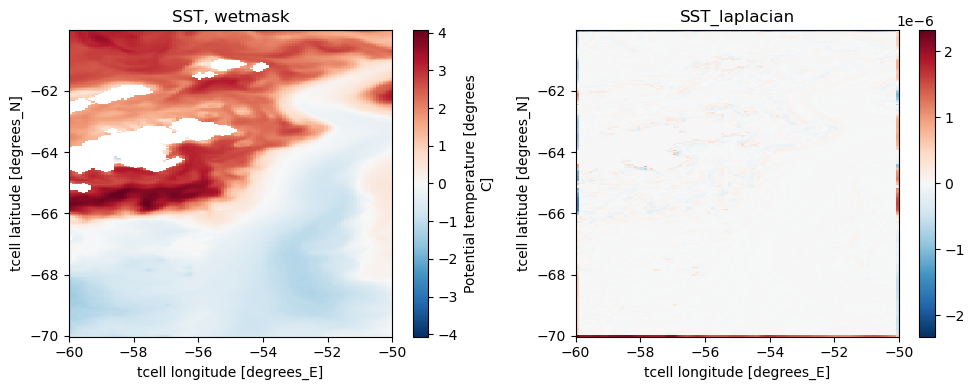

In [38]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
simple_temp.where(simple_grid).plot(ax=ax0)
sst_lap.plot(ax=ax1)

ax0.set_title('SST, wetmask')
ax1.set_title('SST_laplacian')
plt.tight_layout();

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>

In [43]:
sst = ds.temp.isel(st_ocean=0)
sss = ds.salt.isel(st_ocean=0)

In [44]:
SST_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, sst, dxu, dyu, axis=axis)
SSS_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, sss, dxu, dyu, axis=axis)

In [46]:
SST_lap = kappa * Laplacian(grid, eroded_mask1, dxt, dyt, area_t, sst, dxu, dyu, axis=axis)
SSS_lap = kappa * Laplacian(grid, eroded_mask1, dxt, dyt, area_t, sss, dxu, dyu, axis=axis)

In [13]:
SSS_lap

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

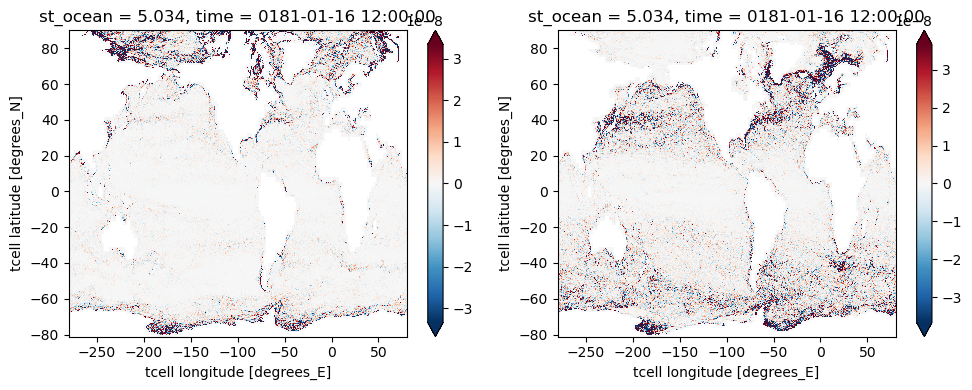

In [47]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
SSS_lap[0].plot(robust=True, ax=ax0)
SST_lap[0].plot(robust=True, ax=ax1)
plt.tight_layout();

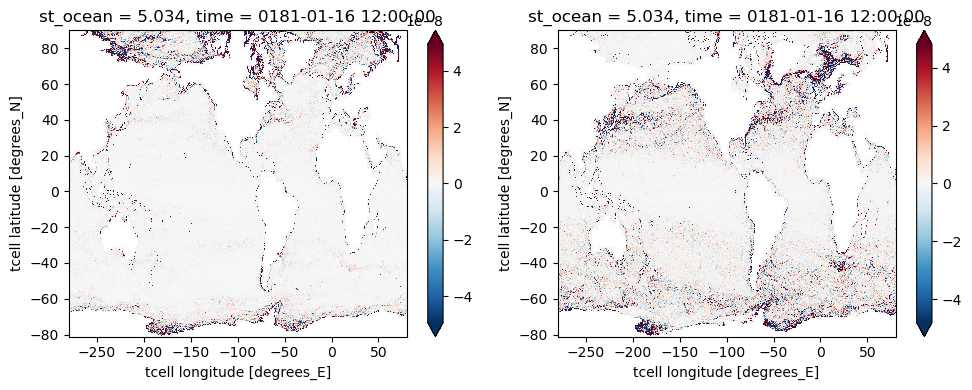

In [10]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
SSS_lap[0].plot(robust=True, ax=ax0)
SST_lap[0].plot(robust=True, ax=ax1)
plt.tight_layout();

# 2) Convert to density tendency <a class="anchor" id='second-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [48]:
rho = xr.apply_ufunc(jmd95numba.rho, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [49]:
rho

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(240, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

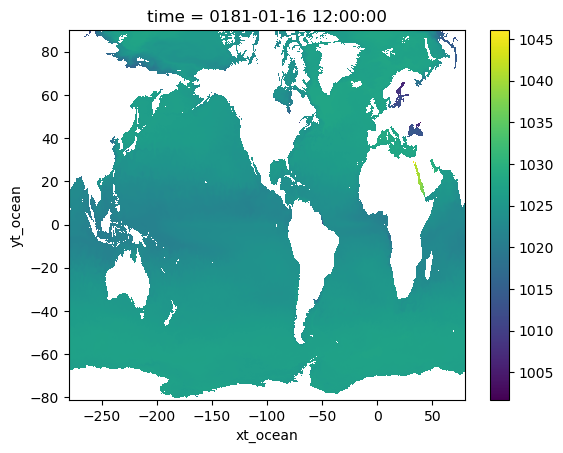

In [14]:
rho[0].plot()

In [50]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(jmd95numba.drhods, sss, sst, 0,
                        output_dtypes=[sss.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [51]:
dens_tend = (drhodt * SST_lap + drhods * SSS_lap) #* rho
dens_tend

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<add, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean  float64 5.034
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

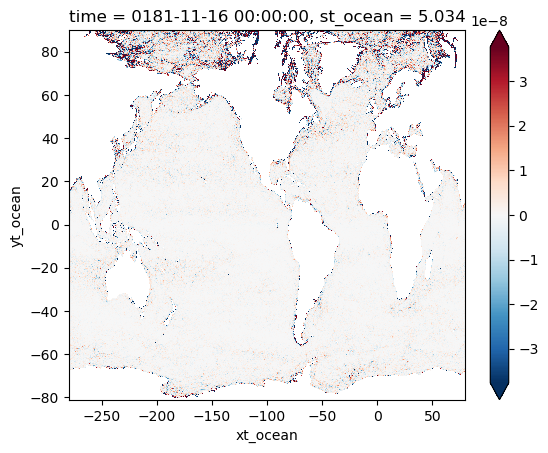

In [17]:
dens_tend.isel(time=10).plot(robust=True);

[Back to top](#top)

# 3) Decompose into the following form <a class='anchor' id='third-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [14]:
rho_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, rho, dxu, dyu, axis=axis)

rho_lap

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [52]:
rho_lap = kappa * Laplacian(grid, eroded_mask1, dxt, dyt, area_t, rho, dxu, dyu, axis=axis)

rho_lap

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

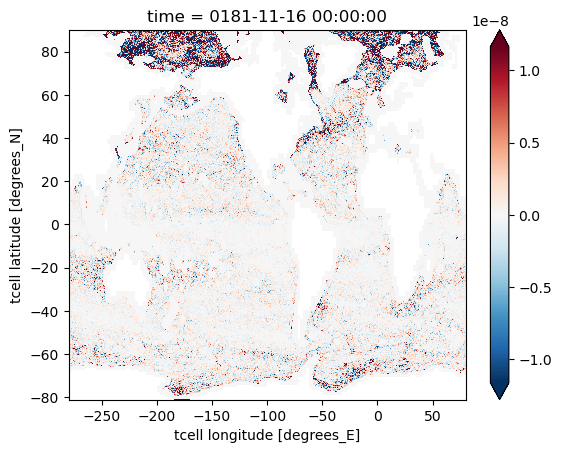

In [23]:
rho_lap[10].plot(robust=True);

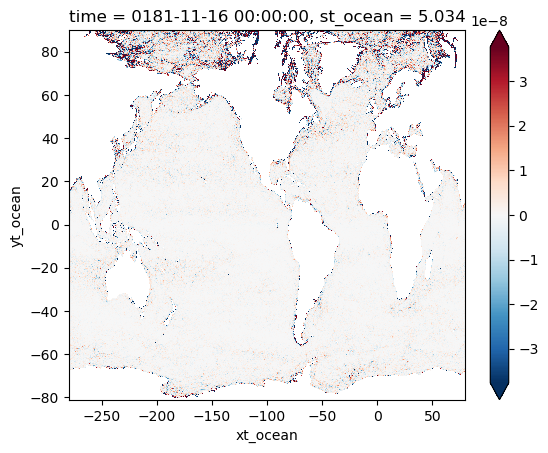

In [39]:
dens_tend[10].plot(robust=True)

In [50]:
ds.xt_ocean[2200]

<xarray.DataArray 'xt_ocean' ()>
array(-59.95)
Coordinates:
    xt_ocean  float64 -59.95
Attributes:
    cartesian_axis:  X
    long_name:       tcell longitude
    units:           degrees_E

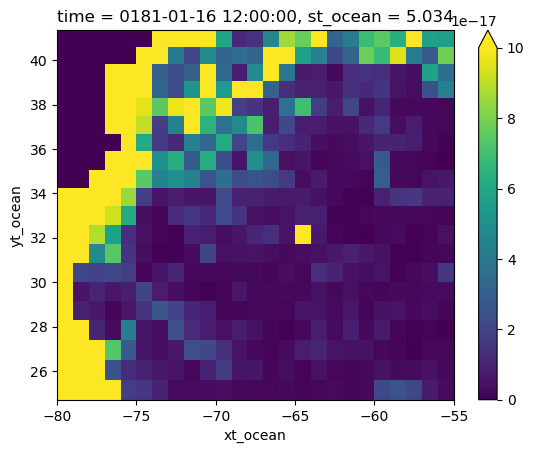

In [53]:
selection = dict(time=0, yt_ocean=slice(1500,1700), xt_ocean=slice(2000,2250))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

(dens_tend**2).isel(**selection).fillna(0.).coarsen(xt_ocean=10, yt_ocean=10).mean().plot(vmin=0, vmax=1e-16)

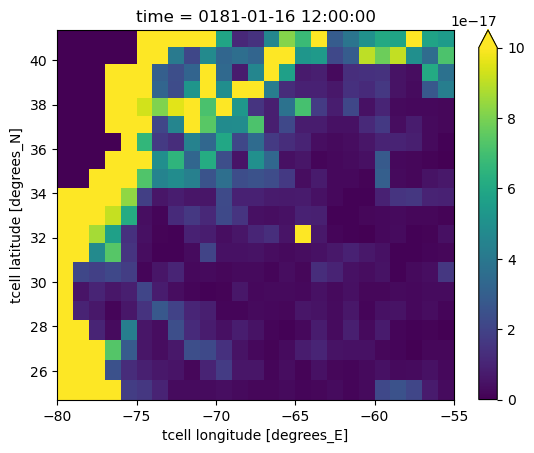

In [54]:
selection = dict(time=0, yt_ocean=slice(1500,1700), xt_ocean=slice(2000,2250))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

(rho_lap**2).isel(**selection).fillna(0.).coarsen(xt_ocean=10, yt_ocean=10).mean().plot(vmin=0, vmax=1e-16)

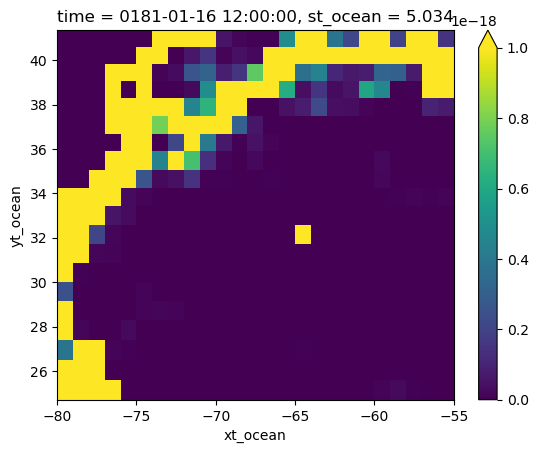

In [57]:
selection = dict(time=0, yt_ocean=slice(1500,1700), xt_ocean=slice(2000,2250))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

((dens_tend-rho_lap)**2).isel(**selection).fillna(0.).coarsen(xt_ocean=10, yt_ocean=10).mean().plot(vmin=0, vmax=1e-18)

In [53]:
cabbeling = dens_tend - rho_lap

In [21]:
cabbeling

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<sub, shape=(240, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean  float64 5.034
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [55]:
selection = dict(xt_ocean=slice(-75,-25), yt_ocean=slice(25,60))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

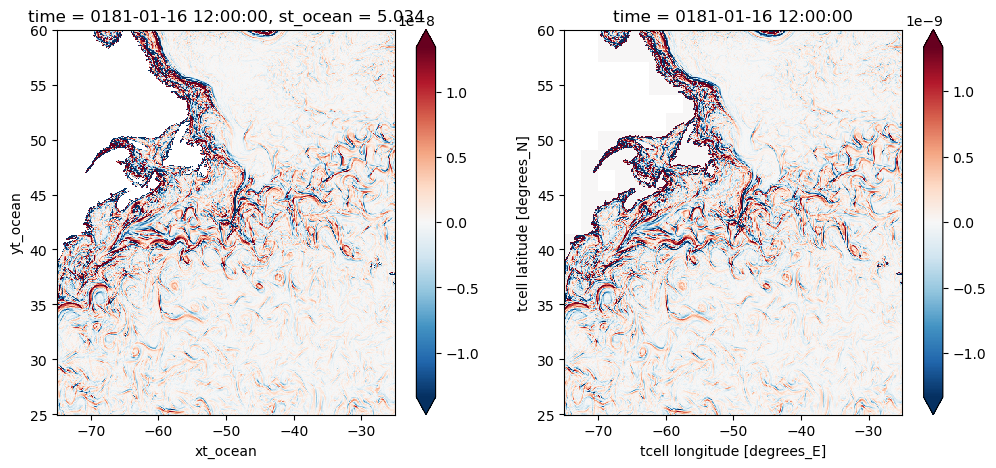

In [28]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
(dens_tend).isel(time=0).sel(**selection).plot(robust=True,ax=ax0)
(rho_lap).isel(time=0).sel(**selection).plot(robust=True, ax=ax1)

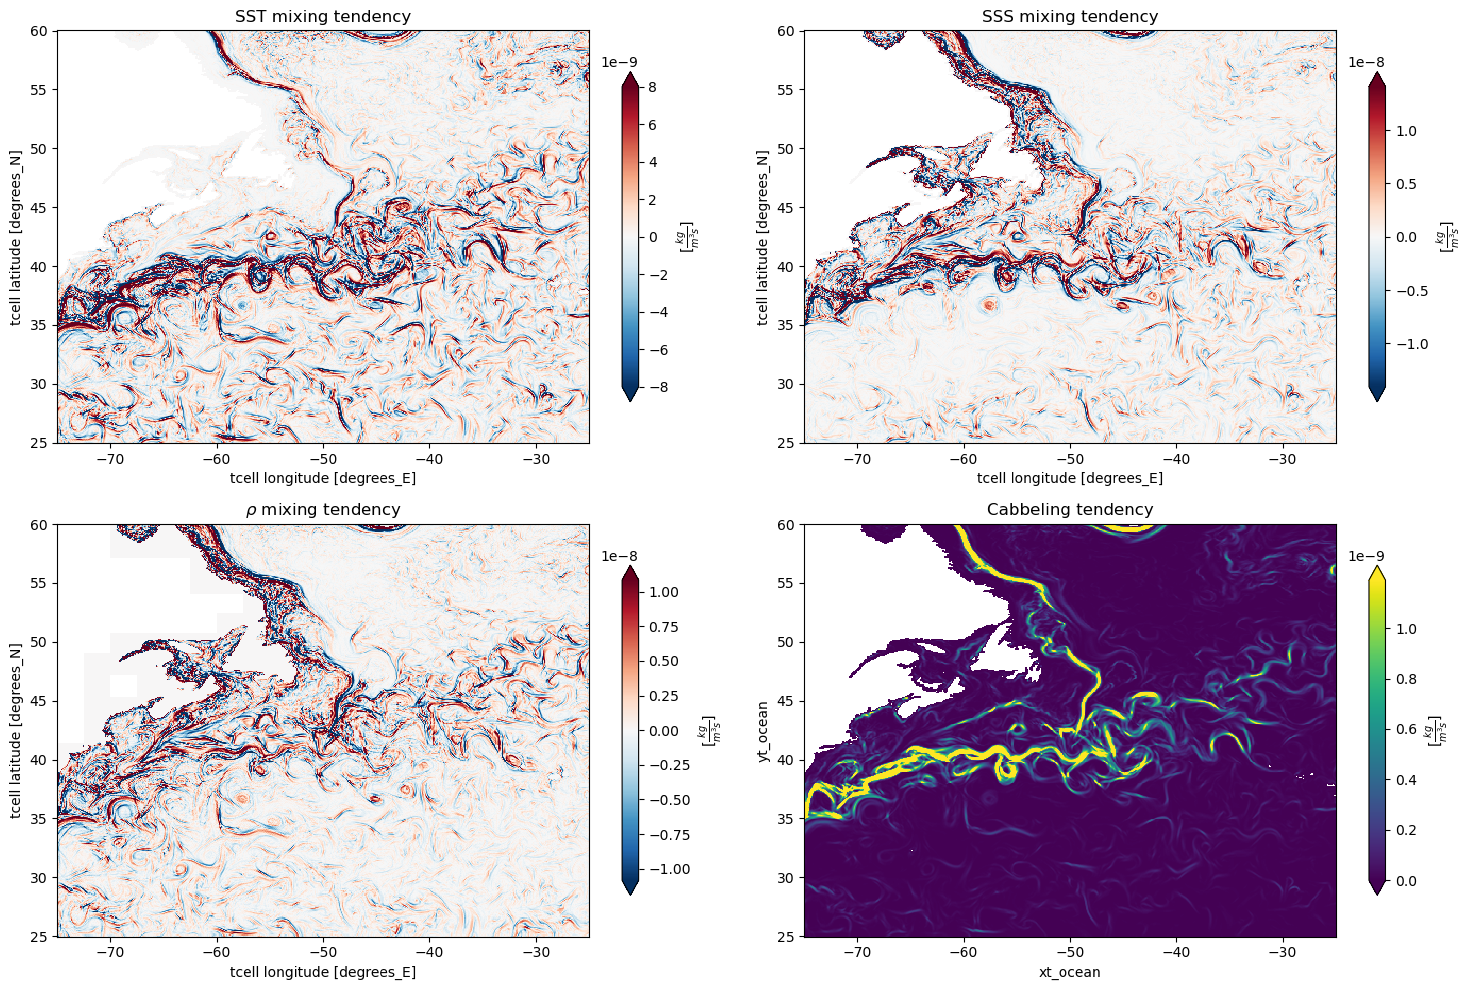

In [56]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_lap*drhodt).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_lap*drhods).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_lap).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

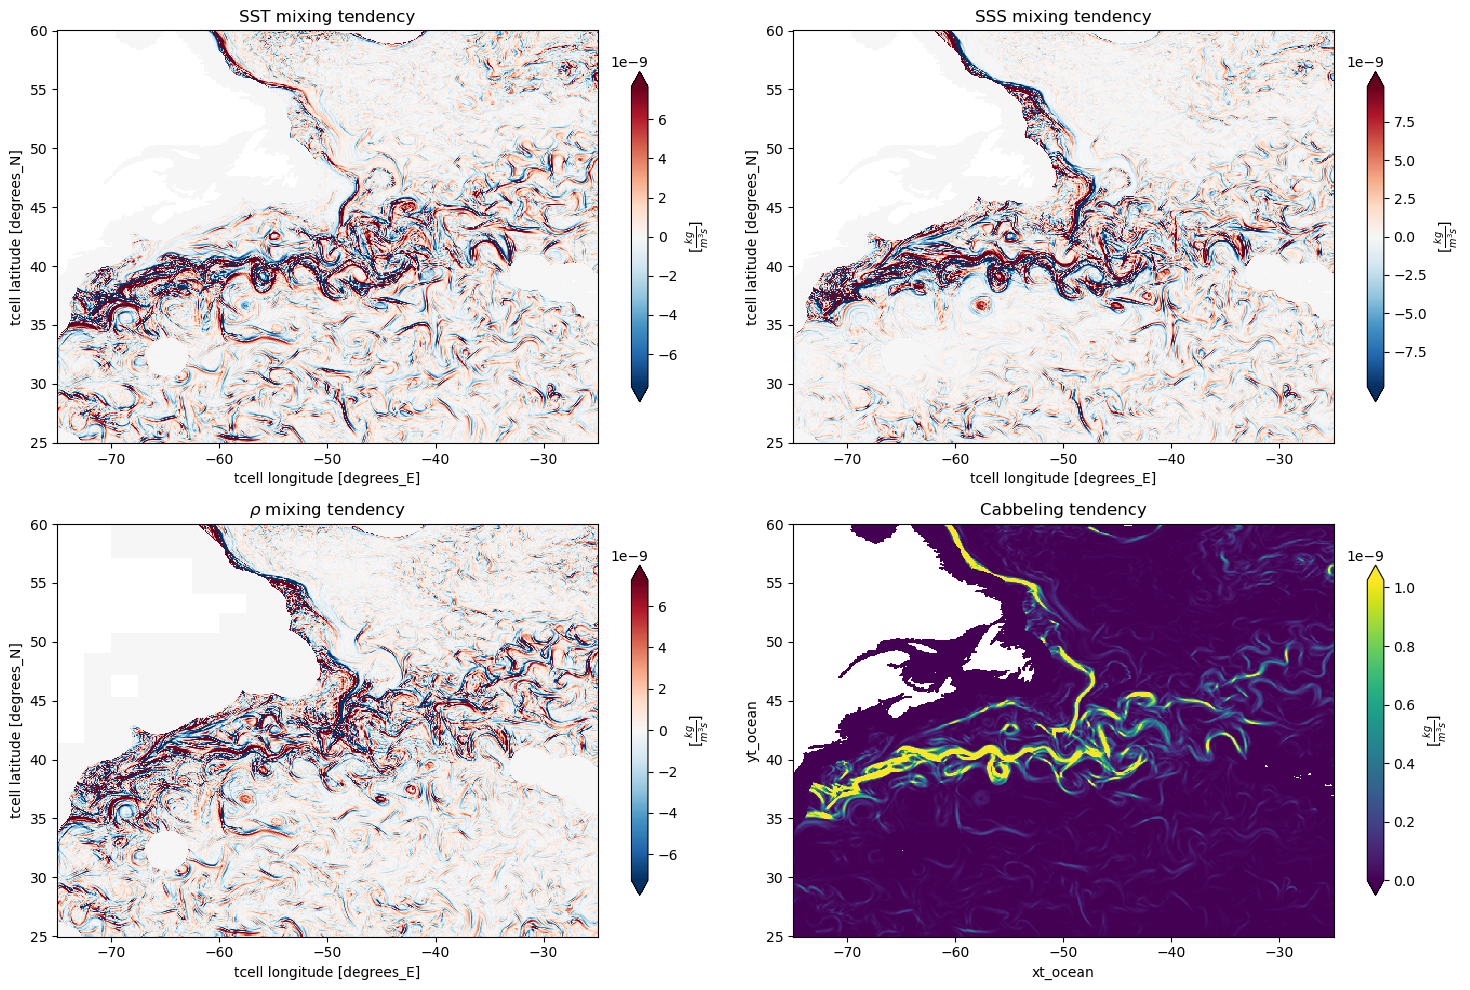

In [24]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_lap*drhodt).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_lap*drhods).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_lap).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

# TESTING

In [57]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-wikm191a
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-wikm191a
  Resolved https://github.com/mathause/regionmask.git to commit 048e2bbee3b5e3ef945139b8a957e8406c4b06df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev45+g048e2bb-py3-none-any.whl size=67327 sha256=03363a16de6e2bc08a9af7903f70da2c4caa17c4ab82ca67328d372ab6a16b9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9d_y_jy/wheels/1a/62/0f/f392f37f9bd2d2d61b9a6b63de17bb421b3f7c2972b03c9934
Successfully built regionmask


In [58]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-1zro1q4y
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-1zro1q4y
  Resolved https://github.com/jbusecke/xmip.git to commit 16ce8bbe4df5ea4150f7da516eeccc6fd06131a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.2.dev4+g16ce8bb-py3-none-any.whl size=58752 sha256=b6b65dabf9588d76173b1fb92f466ebb4567c90d20b6267f8be2c388e5826fdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6xwyh8u/wheels/14/81/1d/2382ef5c4df3bc79c5b5a3c37400af047e5a775a4b2cf79b42
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  Attempting uninstall: xmip
    Found existing installation: x

In [59]:
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

<GeoAxes: >

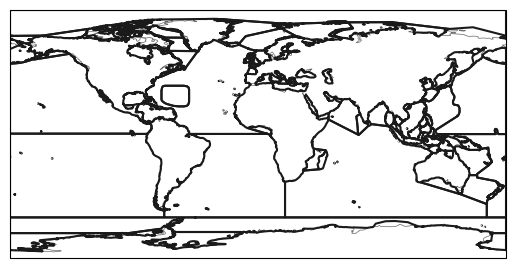

In [60]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [61]:
da = ds.temp.isel(time=0, st_ocean=0).squeeze()

In [62]:
da_renamed = da.rename({'geolat_t':'lat', 'geolon_t':'lon'}).load()

In [63]:
mask = merged_mask(basins, da_renamed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/regionmask/core/mask.py:153: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pygeos/io.py:523: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


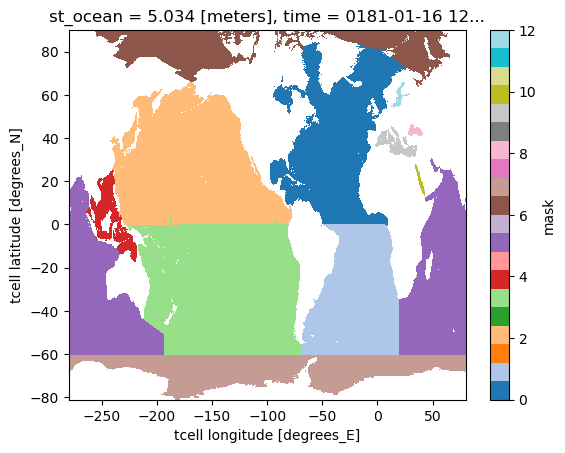

In [46]:
mask.plot(cmap='tab20');

In [64]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [65]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_lap']*ds['drhodt']).rename('sst'),
                      (ds['SSS_lap']*ds['drhods']).rename('sss'),
                       ds['rho_lap'].rename('rho_lap'),
                       ds['cabbeling']])
    return newds

In [66]:
tendencies = xr.merge([SST_lap.rename('SST_lap'), SSS_lap.rename('SSS_lap'),
                       drhodt.rename('drhodt'), drhods.rename('drhods'), 
                       rho_lap.drop(['geolon_t', 'geolat_t']).rename('rho_lap'), cabbeling.rename('cabbeling'),
                      rho.rename('rho')])
tendencies = tendencies.drop(['st_ocean', 'geolat_t', 'geolon_t'])

In [67]:
tend = new_ds(tendencies)

In [68]:
tend

<xarray.Dataset>
Dimensions:    (time: 240, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [69]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(mask==basin)
    return tendency_in_basin

In [70]:
all_tendencies = list(tend)

In [71]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([basin_selection(tend[var],
                                       north_atlantic_ocean).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(tend[var], 
                                       south_atlantic_ocean).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(tend[var], 
                                       north_pacific_ocean).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(tend[var], 
                                       south_pacific_ocean).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

In [72]:
rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
mask_bins = np.array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 99.5])
rho = tendencies.rho
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)

In [73]:
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

In [74]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [75]:
natl_hist = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

In [76]:
def ann_mean2(ds):
    fig = plt.figure(figsize=(12,5))
    line_colors=['green', 'orange', 
                 'k', 'blue']#, 'purple', 'yellow'] #order of sst, sss, rho, cab, surf heat, surf salt
    for (i,j) in zip(list(ds.data_vars), line_colors):
        (ds[i].mean('time')/1e6).plot(label=f'{i}', color=j)
    plt.legend()
    #plt.ylim(-20,10)
    plt.ylabel(r'Transformation (Sv)', fontsize=16)
    plt.grid()
    plt.title('Annual Mean Transformation Terms', fontsize=20);

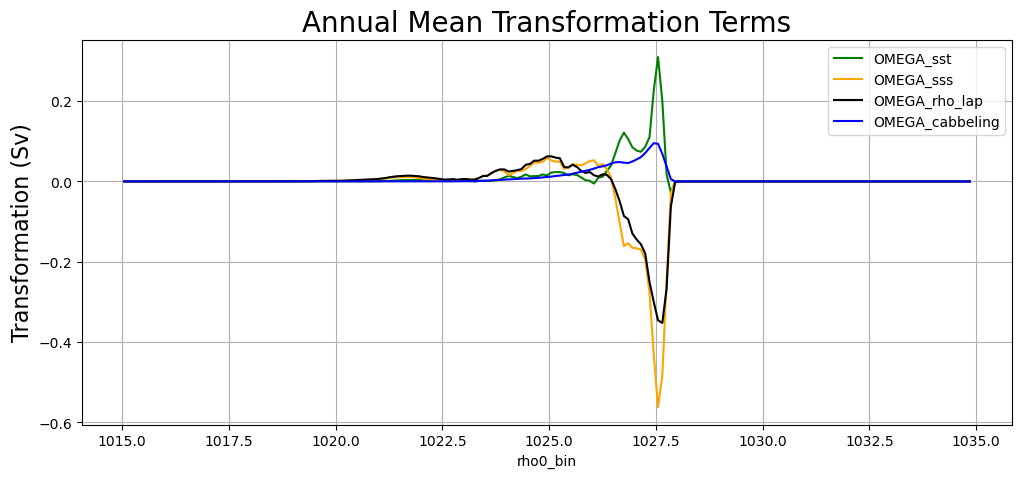

In [48]:
#erodedmask1
ann_mean2(natl_hist)

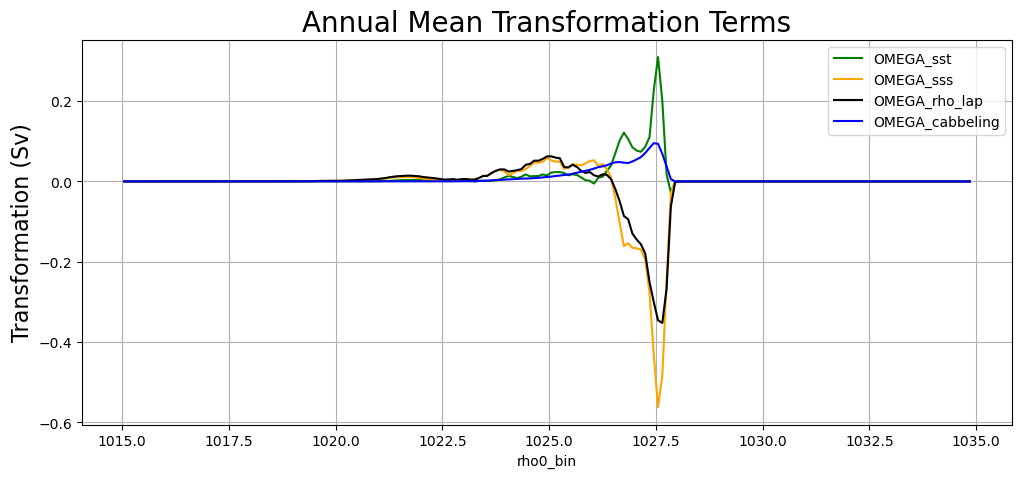

In [48]:
ann_mean2(natl_hist)

## 4) Save the four terms to dataset <a class="anchor" id="fourth-bullet"> </a>

In [48]:
client.restart()

<Client: 'tls://10.0.63.29:8786' processes=26 threads=52, memory=780.00 GiB>

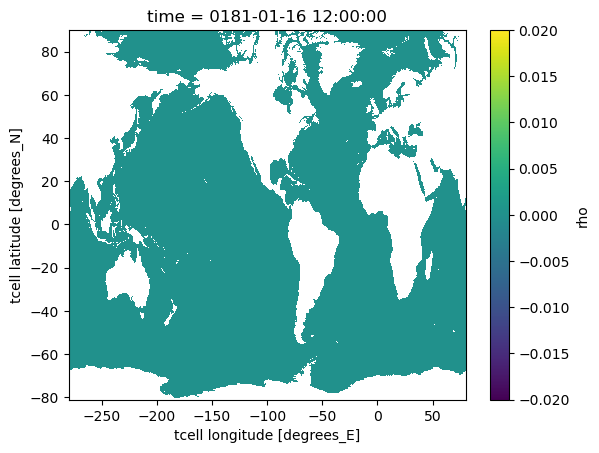

In [51]:
#checking to see if rho is diff in tendencies ds, getting desperate at this pt
(rho[0] - tendencies.rho[0]).plot(vmin=-0.02, vmax=0.02)

In [36]:
tendencies = xr.merge([SST_lap.rename('SST_lap'), SSS_lap.rename('SSS_lap'),
                       drhodt.rename('drhodt'), drhods.rename('drhods'), 
                       rho_lap.drop(['geolon_t', 'geolat_t']).rename('rho_lap'), cabbeling.rename('cabbeling'),
                      rho.rename('rho')])
tendencies = tendencies.drop(['st_ocean', 'geolat_t', 'geolon_t'])

In [27]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 240, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    drhodt     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    drhods     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [28]:
tracers = xr.merge([tendencies.SST_lap.rename('SST_lap'), 
                    tendencies.SSS_lap.rename('SSS_lap')])
drhodts = xr.merge([tendencies.drhodt.rename('drhodt'), 
                    tendencies.drhods.rename('drhods')])
rho_lap_cab = xr.merge([tendencies.rho_lap.rename('rho_lap'),
                        tendencies.rho.rename('rho'),
                        tendencies.cabbeling.rename('cabbeling')])

In [29]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [30]:
#uploading tracer tendency ds for entire 40 yr run
gcsmap_tracer_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/tracer_tendencies_jmd95.zarr')
tracers.to_zarr(gcsmap_tracer_tendencies, mode='w')

In [31]:
#uploading drhodts tendency ds for entire 40 yr run
gcsmap_drhodts_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/drhodts_tendencies_jmd95.zarr')
drhodts.to_zarr(gcsmap_drhodts_tendencies, mode='w')

In [32]:
#uploading rho_bih and cabbeling tendency ds for entire 40 yr run
gcsmap_rho_cab_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/rho_lap_cab_tendencies_jmd95.zarr')
rho_lap_cab.to_zarr(gcsmap_rho_cab_tendencies, mode='w')

In [44]:
cluster.close()
client.close()